In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from netCDF4 import Dataset
import cartopy.crs as ccrs
import xarray as xr
import pysal as ps
import libpysal
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import OPTICS
from sklearn.cluster import KMeans

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/pysal/explore/segregation/network/network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
def optics_labels(idxs,obu,obv,min_obs=8,max_dist=7.):
    # define features for clustering:
    # 1. u-component
    # 2. v-component
    # predictors are stored in a matrix of {n_samples, n_features}
    n_feat = 2
    X = np.nan * np.ones((np.size(idxs),n_feat))
    feat1 = obu[idxs]
    feat2 = obv[idxs]
    X[:,0] = feat1
    X[:,1] = feat2
    # define settings for affinity propagation and generate clustering
    # see for details:
    # https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html#sklearn.cluster.AffinityPropagation
    dampCoef  = 0.70  # can be increased up to 0.95, if not converging - lower value may or may not produce more indiv. clusters
    iterMax   = 500   # set higher than iterCnv
    iterCnv   = 50   # can be increased if not converging (try increasing dampCoef first, though)
    cop       = True
    pref      = None
    affTyp    = 'euclidean'
    outVerb   = False
    randState = 90210  # sets random number seed, for reproducibility
    clustering = OPTICS(
                        min_samples=min_obs,          # how many obs necessary to create a cluster
                        max_eps=np.sqrt(2*max_dist),  # how close in X-space obs need to be to be clustered
                        n_jobs=1
                       ).fit(X)
    # compute empirical centers for all clusters with labels != -1
    cluLabels = np.unique(clustering.labels_)
    mask = np.ones(len(cluLabels), dtype=bool)
    mask[np.where(cluLabels==-1)] = False
    cluLabels = cluLabels[mask]  # removing the clustering.lanels_==-1 non-cluster
    nClusters = np.size(cluLabels)
    clusterCenters = np.nan * np.ones((nClusters,2))
    for i in range(np.size(cluLabels)):
        clu = cluLabels[i]
        mems = np.where(clustering.labels_ == clu)[0]
        clusterCenters[i,0] = np.mean(feat1[mems])
        clusterCenters[i,1] = np.mean(feat2[mems])
        
    return clustering.labels_, clusterCenters

def haversine_np(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [3]:
data_dir='test-data/ops.v16.3.2023040300'
diag_file=data_dir+'/diag_conv_uv_ges.2023040300.nc4'
diag_hdl=Dataset(diag_file)
ob_use=np.asarray(diag_hdl.variables['Analysis_Use_Flag']).squeeze()
ob_typ=np.asarray(diag_hdl.variables['Observation_Type']).squeeze()
ob_sty=np.asarray(diag_hdl.variables['Observation_Subtype']).squeeze()
ob_pre=np.asarray(diag_hdl.variables['Pressure']).squeeze()
ob_lat=np.asarray(diag_hdl.variables['Latitude']).squeeze()
ob_lon=np.asarray(diag_hdl.variables['Longitude']).squeeze()
ob_tim=np.asarray(diag_hdl.variables['Time']).squeeze()
ob_uwd=np.asarray(diag_hdl.variables['u_Observation']).squeeze()
ob_vwd=np.asarray(diag_hdl.variables['v_Observation']).squeeze()
fix=np.where(ob_lon>180.)
ob_lon[fix]=ob_lon[fix]-360.

In [4]:
# Pre-screening for pressure and time into discrete groups, then use DistanceBand grouping
# and pressure/time NearestNeighbors against all obs to reach out and include obs outside
# of initial screening. Use this expanded group to test for similarity via clustering with
# affinity propagation
#
# Perform similarity-based clustering on DistanceBand connected-groups, which can include
# multiple proximity-based clusters but will contain no observations with proximity-neighbors
# outside of the connected-group.
#
# define index of all qualifiable observations (meeting use and typ requirements)
allidx=np.where((ob_use==1.)&(ob_typ>=240)&(ob_typ<=260))[0]
# define index of all searching observations (meeting pressure and time requirements in subset)
thresPres = 50. # +/- range of pressure bin
thresTime = 0.5  # +/- range of time bin
thresUwnd = 5.0
thresVwnd = 5.0
srcPres = 450.  # center of pressure bin
srcTime = -2.5  # center of time bin
minPres = srcPres - thresPres
maxPres = srcPres + thresPres
minTime = srcTime - thresTime
maxTime = srcTime + thresTime
srcidx=np.intersect1d(allidx,np.where((ob_pre <= maxPres)&(ob_pre >= minPres) &
                                      (ob_tim <= maxTime)&(ob_tim >= minTime))[0])
# define index of all expanding observations (qualifiable and within threshPres and threshTime of pressure/time req.)
minPresExp = minPres - thresPres
maxPresExp = maxPres + thresPres
minTimeExp = minTime - thresTime
maxTimeExp = maxTime + thresTime
expidx=np.intersect1d(allidx,np.where((ob_pre <= maxPresExp)&(ob_pre >= minPresExp) &
                                      (ob_tim <= maxTimeExp)&(ob_tim >= minTimeExp))[0])
print('{:d} observations in total'.format(np.size(allidx)))
print('{:d} observations in search'.format(np.size(srcidx)))
print('{:d} observations in expanded range'.format(np.size(expidx)))

582778 observations in total
13835 observations in search
39721 observations in expanded range


In [5]:
# Construct a geopandas point dataset that contains all relevant ob-info
point_list=[]
nob_list=[]
for i in expidx:
    point_list.append(Point(ob_lon[i],ob_lat[i]))
d = {'geometry': point_list, 
     'lat': list(ob_lat[expidx]),
     'lon': list(ob_lon[expidx]),
     'pre': list(ob_pre[expidx]),
     'tim': list(ob_tim[expidx]),
     'uob': list(ob_uwd[expidx]),
     'vob': list(ob_vwd[expidx]),
     'ob_idx': list(expidx),
     'clusterIndex': -1  # placeholder, -1 == no assigned cluster
    }
gdf = gpd.GeoDataFrame(d, crs="EPSG:4326")
# Transform gdf into cylindrical equidistant projection, where Point() units are in m
gdfE = gdf.to_crs("EPSG:4087")
gdfE

,geometry,lat,lon,pre,tim,uob,vob,ob_idx,clusterIndex
0,POINT (111319.491 -9034690.280),-81.160004,1.000000,425.000000,-2.550000,-3.314330,13.293052,0,-1
1,POINT (939536.456 -9013539.305),-80.970001,8.440000,450.000000,-2.550000,-13.800393,8.292113,1,-1
2,POINT (921725.354 -9082556.846),-81.589996,8.280000,437.000000,-2.550000,-11.190902,9.062214,2,-1
3,POINT (551031.458 -9124858.796),-81.970001,4.950000,412.000000,-2.550000,-8.955636,14.332013,3,-1
4,POINT (732482.241 -9122631.931),-81.949997,6.580000,412.000000,-2.550000,-10.281547,13.159780,4,-1
...,...,...,...,...,...,...,...,...,...
39716,POINT (-391109.589 8010216.681),71.957001,-3.513397,550.000000,-2.300000,9.053615,10.414992,1850177,-1
39717,POINT (-262257.143 8251001.813),74.120010,-2.355896,550.000000,-2.050000,5.768426,9.600274,1850178,-1
39718,POINT (-342295.204 8191590.708),73.586311,-3.074890,537.000000,-2.050000,5.304892,8.828823,1850179,-1
39719,POINT (-374711.299 7996491.138),71.833702,-3.366089,525.000000,-2.050000,9.522121,13.106075,1850181,-1


In [6]:
# Define weights by a DistanceBand cutoff distance around each ob
distThreshold=1000.*100. # m
w=libpysal.weights.distance.DistanceBand.from_dataframe(gdfE,threshold=distThreshold) # threshold in m

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2821 disconnected components.
 There are 1241 islands with ids: 0, 3, 15, 23, 24, 25, 66, 751, 752, 753, 754, 770, 775, 785, 787, 788, 803, 809, 815, 816, 819, 847, 850, 852, 856, 979, 999, 1000, 1463, 1596, 1767, 1769, 1773, 1774, 1790, 1796, 1806, 1819, 1824, 1826, 1841, 1842, 1843, 1844, 1860, 1910, 1920, 1922, 1932, 1935, 1949, 1952, 1953, 1956, 1965, 1970, 1982, 1995, 1996, 2002, 2014, 2022, 2150, 2164, 2619, 2623, 2631, 2662, 2673, 2680, 2687, 2693, 2694, 2701, 2702, 2708, 2711, 2715, 2716, 2717, 2718, 2721, 2722, 2728, 2729, 2730, 2748, 2760, 2766, 2782, 2807, 2809, 2810, 2811, 2812, 2813, 2816, 2821, 2848, 2856, 2859, 2863, 2864, 2866, 2903, 2905, 2907, 2910, 2928, 2929, 2953, 3538, 3546, 3571, 3580, 3619, 3728, 3738, 3739, 3747, 3751, 3752, 3755, 3758, 3761, 3764, 3767, 3776, 3779, 3782, 3784, 378

In [7]:
# trim islands from gdfE, as these are 1-member clusters by definition, recompute w
gdfE_islands=gdfE.iloc[w.islands]
gdfE_islands=gdfE_islands.reset_index() # Resets index numbering to start at 0
gdfE=gdfE.drop(index=w.islands)
gdfE=gdfE.reset_index() # Resets index numbering to start at 0
w = libpysal.weights.distance.DistanceBand.from_dataframe(gdfE,threshold=distThreshold) # threshold in m

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 1580 disconnected components.
  warnings.warn(message)


In [8]:
# attach component-groups to gdfE
gdfE = gdfE.assign(compGroup=w.component_labels)

In [9]:
# define a cluster index value
clusterID = -1  # first valid cluster will increment, so clusterIndex will begin at 0
# loop over component-groups
for ic in np.unique(gdfE['compGroup'].values):
    # extract all component-neighbors from a component of w
    gdfEsub = gdfE.loc[gdfE['compGroup']==ic]
    compIDX = gdfEsub.index
    print('operating on component group {:d} of {:d}, with {:d} observations'.format(ic,np.size(np.unique(gdfE['compGroup'].values)),np.size(compIDX)))
    # compute pressure and time proximity-neighbor lists among expidx[compIDX]
    neighPres = NearestNeighbors(radius=thresPres)
    neighPres.fit(np.reshape(gdfEsub['pre'].values,(-1,1)))
    neighPresList = neighPres.radius_neighbors(np.reshape(gdfEsub['pre'].values,(-1,1)),return_distance=False)
    neighTime = NearestNeighbors(radius=thresTime)
    neighTime.fit(np.reshape(gdfEsub['tim'].values,(-1,1)))
    neighTimeList = neighTime.radius_neighbors(np.reshape(gdfEsub['tim'].values,(-1,1)),return_distance=False)
    # compute uwd and vwd proximity-neighbor lists
    neighUwnd = NearestNeighbors(radius=thresUwnd)
    neighUwnd.fit(np.reshape(gdfEsub['uob'].values,(-1,1)))
    neighUwndList = neighUwnd.radius_neighbors(np.reshape(gdfEsub['uob'].values,(-1,1)),return_distance=False)
    neighVwnd = NearestNeighbors(radius=thresVwnd)
    neighVwnd.fit(np.reshape(gdfEsub['vob'].values,(-1,1)))
    neighVwndList = neighVwnd.radius_neighbors(np.reshape(gdfEsub['vob'].values,(-1,1)),return_distance=False)
    # 
    # create gdfE subset for component-group
    gdfEsub = gdfE.loc[gdfE['compGroup']==ic]
    gdfEsub = gdfEsub.reset_index()
    # loop through subgroup
    for i in range(len(gdfEsub)):
        # Check if observation i still needs to be assigned to a cluster, if not, skip this loop
        # NOTE: Including this if-check reduces the total number of clusters (i.e. generates larger
        #       clusters) and affects the standard-deviation statistics. It would be worth figuring
        #       out exactly *why* this change takes place.
        if gdfEsub.iloc[i]['clusterIndex'] == -1:
            # Increment clusterID
            clusterID = clusterID + 1
            # Define proximity, pressure, time, and u/v similarity neighbors among subgroup members
            proxlist=np.where(np.isin(gdfEsub['level_0'].values,w.neighbors[gdfEsub['level_0'].values[i]]))[0]
            preslist=neighPresList[i]
            timelist=neighTimeList[i]
            uwndlist=neighUwndList[i]
            vwndlist=neighVwndList[i]
            # Define cluster members by intersection of all neighborhoods
            cluster=np.intersect1d(proxlist,preslist)
            cluster=np.intersect1d(cluster,timelist)
            cluster=np.intersect1d(cluster,uwndlist)
            cluster=np.intersect1d(cluster,vwndlist)
            # Add member i to cluster
            cluster=np.append(i,cluster)
            # assign any member of cluster with a -1 (unassigned) clusterIndex to clusterID
            gdfEsub.iloc[cluster, gdfEsub.columns.get_loc('clusterIndex')] = np.where(gdfEsub.iloc[cluster, gdfEsub.columns.get_loc('clusterIndex')]==-1,
                                                                                      clusterID,
                                                                                      gdfEsub.iloc[cluster, gdfEsub.columns.get_loc('clusterIndex')])
    # assign corresponding members of gdfE a clusterIndex value from gdfEsubcl, following clustering
    gdfE.set_index('index', inplace=True)
    gdfE.update(gdfEsub.set_index('index'))
    gdfE=gdfE.reset_index()  # to recover the initial structure
    # reassert column types (integers tend to turn into floats after update)
    convert_dict = {'ob_idx': int,
                    'clusterIndex': int,
                    'compGroup': int
                   }
    gdfE = gdfE.astype(convert_dict)
    gdfE = gdfE.set_crs("EPSG:4087")

operating on component group 0 of 1580, with 3438 observations
operating on component group 1 of 1580, with 7 observations
operating on component group 2 of 1580, with 2 observations
operating on component group 3 of 1580, with 3 observations
operating on component group 4 of 1580, with 2 observations
operating on component group 5 of 1580, with 3 observations
operating on component group 6 of 1580, with 4 observations
operating on component group 7 of 1580, with 5 observations
operating on component group 8 of 1580, with 128 observations
operating on component group 9 of 1580, with 45 observations
operating on component group 10 of 1580, with 18 observations
operating on component group 11 of 1580, with 7 observations
operating on component group 12 of 1580, with 3 observations
operating on component group 13 of 1580, with 4 observations
operating on component group 14 of 1580, with 3 observations
operating on component group 15 of 1580, with 3 observations
operating on component grou

operating on component group 135 of 1580, with 5 observations
operating on component group 136 of 1580, with 4 observations
operating on component group 137 of 1580, with 9 observations
operating on component group 138 of 1580, with 5 observations
operating on component group 139 of 1580, with 6 observations
operating on component group 140 of 1580, with 2 observations
operating on component group 141 of 1580, with 40 observations
operating on component group 142 of 1580, with 6 observations
operating on component group 143 of 1580, with 5 observations
operating on component group 144 of 1580, with 3 observations
operating on component group 145 of 1580, with 3 observations
operating on component group 146 of 1580, with 4 observations
operating on component group 147 of 1580, with 3 observations
operating on component group 148 of 1580, with 2 observations
operating on component group 149 of 1580, with 7 observations
operating on component group 150 of 1580, with 5 observations
operati

operating on component group 268 of 1580, with 3 observations
operating on component group 269 of 1580, with 3 observations
operating on component group 270 of 1580, with 2 observations
operating on component group 271 of 1580, with 2 observations
operating on component group 272 of 1580, with 2 observations
operating on component group 273 of 1580, with 12 observations
operating on component group 274 of 1580, with 3 observations
operating on component group 275 of 1580, with 3 observations
operating on component group 276 of 1580, with 9 observations
operating on component group 277 of 1580, with 5 observations
operating on component group 278 of 1580, with 7 observations
operating on component group 279 of 1580, with 17 observations
operating on component group 280 of 1580, with 7 observations
operating on component group 281 of 1580, with 24 observations
operating on component group 282 of 1580, with 12 observations
operating on component group 283 of 1580, with 3 observations
oper

operating on component group 402 of 1580, with 5 observations
operating on component group 403 of 1580, with 5 observations
operating on component group 404 of 1580, with 4 observations
operating on component group 405 of 1580, with 7 observations
operating on component group 406 of 1580, with 4 observations
operating on component group 407 of 1580, with 2 observations
operating on component group 408 of 1580, with 4 observations
operating on component group 409 of 1580, with 2 observations
operating on component group 410 of 1580, with 5 observations
operating on component group 411 of 1580, with 2 observations
operating on component group 412 of 1580, with 5 observations
operating on component group 413 of 1580, with 2 observations
operating on component group 414 of 1580, with 3 observations
operating on component group 415 of 1580, with 4 observations
operating on component group 416 of 1580, with 2 observations
operating on component group 417 of 1580, with 3 observations
operatin

operating on component group 535 of 1580, with 9 observations
operating on component group 536 of 1580, with 2 observations
operating on component group 537 of 1580, with 327 observations
operating on component group 538 of 1580, with 2 observations
operating on component group 539 of 1580, with 12 observations
operating on component group 540 of 1580, with 31 observations
operating on component group 541 of 1580, with 4 observations
operating on component group 542 of 1580, with 4 observations
operating on component group 543 of 1580, with 165 observations
operating on component group 544 of 1580, with 10 observations
operating on component group 545 of 1580, with 10 observations
operating on component group 546 of 1580, with 2 observations
operating on component group 547 of 1580, with 3 observations
operating on component group 548 of 1580, with 2 observations
operating on component group 549 of 1580, with 2 observations
operating on component group 550 of 1580, with 4 observations


operating on component group 669 of 1580, with 11 observations
operating on component group 670 of 1580, with 36 observations
operating on component group 671 of 1580, with 4 observations
operating on component group 672 of 1580, with 3 observations
operating on component group 673 of 1580, with 2 observations
operating on component group 674 of 1580, with 5 observations
operating on component group 675 of 1580, with 759 observations
operating on component group 676 of 1580, with 5 observations
operating on component group 677 of 1580, with 47 observations
operating on component group 678 of 1580, with 6 observations
operating on component group 679 of 1580, with 4 observations
operating on component group 680 of 1580, with 4 observations
operating on component group 681 of 1580, with 2 observations
operating on component group 682 of 1580, with 5 observations
operating on component group 683 of 1580, with 8 observations
operating on component group 684 of 1580, with 11 observations
op

operating on component group 803 of 1580, with 4 observations
operating on component group 804 of 1580, with 5 observations
operating on component group 805 of 1580, with 2 observations
operating on component group 806 of 1580, with 2 observations
operating on component group 807 of 1580, with 2 observations
operating on component group 808 of 1580, with 80 observations
operating on component group 809 of 1580, with 2 observations
operating on component group 810 of 1580, with 3 observations
operating on component group 811 of 1580, with 6 observations
operating on component group 812 of 1580, with 2 observations
operating on component group 813 of 1580, with 2 observations
operating on component group 814 of 1580, with 6 observations
operating on component group 815 of 1580, with 7 observations
operating on component group 816 of 1580, with 4 observations
operating on component group 817 of 1580, with 2 observations
operating on component group 818 of 1580, with 9 observations
operati

operating on component group 937 of 1580, with 2 observations
operating on component group 938 of 1580, with 2 observations
operating on component group 939 of 1580, with 151 observations
operating on component group 940 of 1580, with 3 observations
operating on component group 941 of 1580, with 4 observations
operating on component group 942 of 1580, with 355 observations
operating on component group 943 of 1580, with 18 observations
operating on component group 944 of 1580, with 25 observations
operating on component group 945 of 1580, with 4 observations
operating on component group 946 of 1580, with 3 observations
operating on component group 947 of 1580, with 5 observations
operating on component group 948 of 1580, with 7 observations
operating on component group 949 of 1580, with 8 observations
operating on component group 950 of 1580, with 3 observations
operating on component group 951 of 1580, with 6 observations
operating on component group 952 of 1580, with 2 observations
op

operating on component group 1068 of 1580, with 6 observations
operating on component group 1069 of 1580, with 3 observations
operating on component group 1070 of 1580, with 7 observations
operating on component group 1071 of 1580, with 3 observations
operating on component group 1072 of 1580, with 6 observations
operating on component group 1073 of 1580, with 3 observations
operating on component group 1074 of 1580, with 4 observations
operating on component group 1075 of 1580, with 3 observations
operating on component group 1076 of 1580, with 7 observations
operating on component group 1077 of 1580, with 20 observations
operating on component group 1078 of 1580, with 8 observations
operating on component group 1079 of 1580, with 5 observations
operating on component group 1080 of 1580, with 3 observations
operating on component group 1081 of 1580, with 13 observations
operating on component group 1082 of 1580, with 2 observations
operating on component group 1083 of 1580, with 4 obs

operating on component group 1198 of 1580, with 9 observations
operating on component group 1199 of 1580, with 30 observations
operating on component group 1200 of 1580, with 9 observations
operating on component group 1201 of 1580, with 2 observations
operating on component group 1202 of 1580, with 3 observations
operating on component group 1203 of 1580, with 3 observations
operating on component group 1204 of 1580, with 2 observations
operating on component group 1205 of 1580, with 4 observations
operating on component group 1206 of 1580, with 2 observations
operating on component group 1207 of 1580, with 3 observations
operating on component group 1208 of 1580, with 6 observations
operating on component group 1209 of 1580, with 2 observations
operating on component group 1210 of 1580, with 8 observations
operating on component group 1211 of 1580, with 6 observations
operating on component group 1212 of 1580, with 4 observations
operating on component group 1213 of 1580, with 3 obse

operating on component group 1330 of 1580, with 3 observations
operating on component group 1331 of 1580, with 15 observations
operating on component group 1332 of 1580, with 2 observations
operating on component group 1333 of 1580, with 130 observations
operating on component group 1334 of 1580, with 10 observations
operating on component group 1335 of 1580, with 2 observations
operating on component group 1336 of 1580, with 4 observations
operating on component group 1337 of 1580, with 2 observations
operating on component group 1338 of 1580, with 6 observations
operating on component group 1339 of 1580, with 26 observations
operating on component group 1340 of 1580, with 2 observations
operating on component group 1341 of 1580, with 3 observations
operating on component group 1342 of 1580, with 25 observations
operating on component group 1343 of 1580, with 13 observations
operating on component group 1344 of 1580, with 2 observations
operating on component group 1345 of 1580, with 

operating on component group 1460 of 1580, with 5 observations
operating on component group 1461 of 1580, with 6 observations
operating on component group 1462 of 1580, with 2 observations
operating on component group 1463 of 1580, with 2 observations
operating on component group 1464 of 1580, with 2 observations
operating on component group 1465 of 1580, with 2 observations
operating on component group 1466 of 1580, with 2 observations
operating on component group 1467 of 1580, with 9 observations
operating on component group 1468 of 1580, with 29 observations
operating on component group 1469 of 1580, with 3 observations
operating on component group 1470 of 1580, with 3 observations
operating on component group 1471 of 1580, with 2 observations
operating on component group 1472 of 1580, with 4 observations
operating on component group 1473 of 1580, with 3 observations
operating on component group 1474 of 1580, with 2 observations
operating on component group 1475 of 1580, with 9 obse

In [10]:
# Assign each observation in gdfE_islands to its own cluster, incrementing from max(gdfE['clusterIndex'])
gdfE_islands['clusterIndex']=np.arange(max(gdfE['clusterIndex'])+1,max(gdfE['clusterIndex'])+1+len(gdfE_islands))
# Concatenate gdfE and gdfE_islands together to regenerate entire dataframe
gdfE2 = gpd.GeoDataFrame(pd.concat([gdfE,gdfE_islands], ignore_index=True, verify_integrity=False, sort=False))
gdfE2

,index,geometry,lat,lon,pre,tim,uob,vob,ob_idx,clusterIndex,compGroup
0,1,POINT (939536.456 -9013539.305),-80.970001,8.440000,450.000000,-2.550000,-13.800393,8.292113,1,0,0.0
1,2,POINT (921725.354 -9082556.846),-81.589996,8.280000,437.000000,-2.550000,-11.190902,9.062214,2,0,0.0
2,4,POINT (732482.241 -9122631.931),-81.949997,6.580000,412.000000,-2.550000,-10.281547,13.159780,4,1,0.0
3,5,POINT (765878.109 -9160480.999),-82.290001,6.880000,437.000000,-2.550000,-9.800718,5.211134,5,2,0.0
4,6,POINT (982951.095 -9154914.685),-82.239998,8.830000,412.000000,-2.550000,-9.447250,10.867818,6,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...
39716,39704,POINT (-320865.659 8491482.895),76.280289,-2.882385,448.600006,-2.583333,0.753638,14.380265,1850132,15994,NaN
39717,39705,POINT (-465436.955 8468184.040),76.070992,-4.181091,449.299988,-2.583333,0.599906,8.579051,1850133,15995,NaN
39718,39706,POINT (-522037.726 8376085.064),75.243652,-4.689545,446.700012,-2.583333,2.865243,9.371787,1850141,15996,NaN
39719,39707,POINT (-417505.843 8356924.849),75.071533,-3.750519,443.299988,-2.583333,1.888975,15.384465,1850142,15997,NaN


In [11]:
np.max(gdfE2['clusterIndex'].values)
nMems=[]
for i in range(np.max(gdfE2['clusterIndex'].values)):
    nMems.append(len(gdfE2.loc[gdfE2['clusterIndex']==i]))
nMems=np.asarray(nMems)

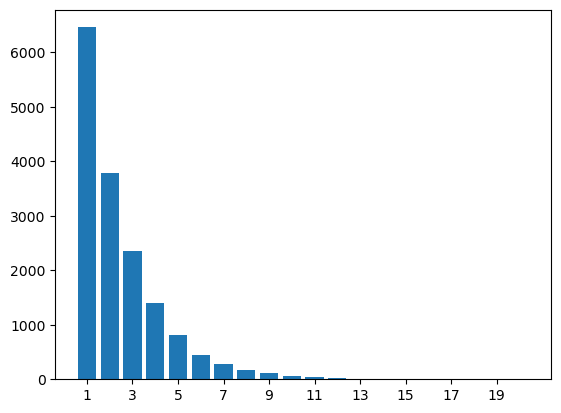

39721 observations reduced to 15999 clusters


In [12]:
h,x=np.histogram(a=nMems,bins=np.arange(0.5,20.51,1.))
xc=0.5*(x[0:-1] + x[1:])
plt.bar(x=xc,height=h)
plt.xticks(ticks=xc[::2],labels=xc[::2].astype(int))
plt.show()
print('{:d} observations reduced to {:d} clusters'.format(len(gdfE2),np.size(np.unique(gdfE2['clusterIndex']))))

In [13]:
# sanity check: standard deviation of distance from [lat=0.,lon=0.], pressure, time, uob, and vob per cluster
cids = np.unique(gdfE['clusterIndex'].values)
stdv_dist=np.nan * np.ones((np.size(cids),))
stdv_pres=np.nan * np.ones((np.size(cids),))
stdv_time=np.nan * np.ones((np.size(cids),))
stdv_uwnd=np.nan * np.ones((np.size(cids),))
stdv_vwnd=np.nan * np.ones((np.size(cids),))
for i in range(np.size(cids)):
    cid = cids[i]
    if np.size(gdfE.loc[gdfE['clusterIndex']==cid,'lat'].values) > 1:
        stdv_dist[i] = np.std(haversine_np(gdfE.loc[gdfE['clusterIndex']==cid,'lat'].values,
                                           gdfE.loc[gdfE['clusterIndex']==cid,'lon'].values,
                                           0.,
                                           0.))
        stdv_pres[i] = np.std(gdfE.loc[gdfE['clusterIndex']==cid,'pre'].values)
        stdv_time[i] = np.std(gdfE.loc[gdfE['clusterIndex']==cid,'tim'].values)
        stdv_uwnd[i] = np.std(gdfE.loc[gdfE['clusterIndex']==cid,'uob'].values)
        stdv_vwnd[i] = np.std(gdfE.loc[gdfE['clusterIndex']==cid,'vob'].values)
    
    
    

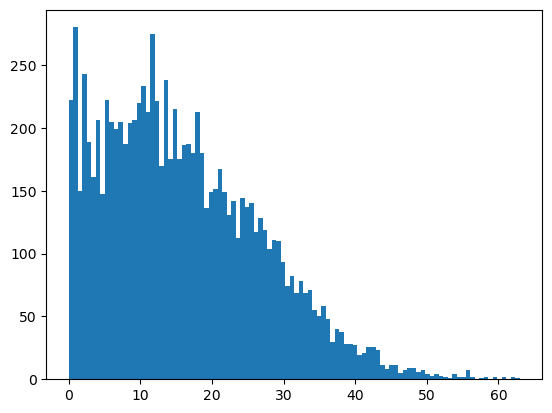

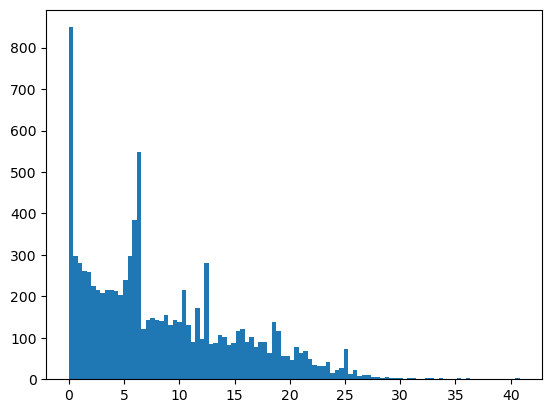

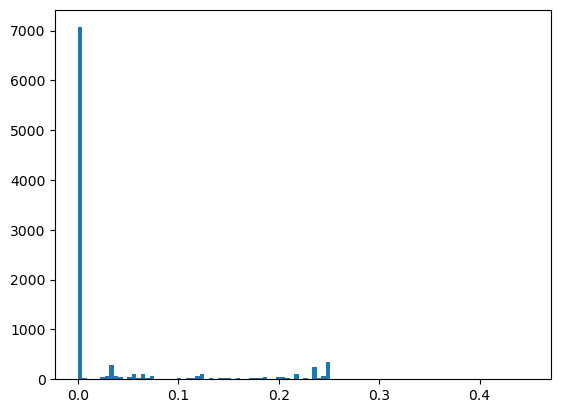

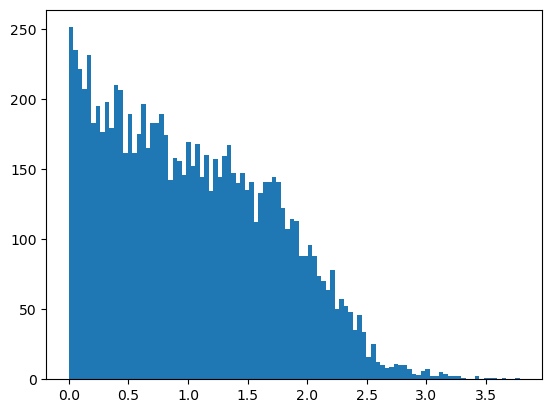

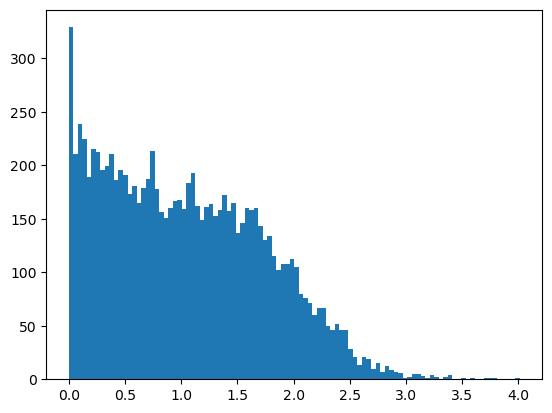

In [14]:
plt.hist(stdv_dist,100)
plt.show()

plt.hist(stdv_pres,100)
plt.show()

plt.hist(stdv_time,100)
plt.show()

plt.hist(stdv_uwnd,100)
plt.show()

plt.hist(stdv_vwnd,100)
plt.show()

In [28]:
stdv_dist

array([33.87646484,  0.        ,  0.        , ..., 23.46728516,
        7.79590988, 29.0690918 ])

In [79]:
gdfE

,index,geometry,lat,lon,pre,tim,uob,vob,ob_idx,clusterIndex,compGroup
0,1,POINT (939536.456 -9013539.305),-80.970001,8.440000,450.0,-2.55,-13.800393,8.292113,1,0,0
1,2,POINT (921725.354 -9082556.846),-81.589996,8.280000,437.0,-2.55,-11.190902,9.062214,2,0,0
2,4,POINT (732482.241 -9122631.931),-81.949997,6.580000,412.0,-2.55,-10.281547,13.159780,4,2,0
3,5,POINT (765878.109 -9160480.999),-82.290001,6.880000,437.0,-2.55,-9.800718,5.211134,5,3,0
4,6,POINT (982951.095 -9154914.685),-82.239998,8.830000,412.0,-2.55,-9.447250,10.867818,6,1,0
...,...,...,...,...,...,...,...,...,...,...,...
38475,39715,POINT (-391979.273 8014469.127),71.995201,-3.521210,550.0,-2.30,9.053615,10.414992,1850176,-1,1578
38476,39716,POINT (-391109.589 8010216.681),71.957001,-3.513397,550.0,-2.30,9.053615,10.414992,1850177,-1,1578
38477,39717,POINT (-262257.143 8251001.813),74.120010,-2.355896,550.0,-2.05,5.768426,9.600274,1850178,-1,1579
38478,39718,POINT (-342295.204 8191590.708),73.586311,-3.074890,537.0,-2.05,5.304892,8.828823,1850179,-1,1579


In [49]:
len(gdfEsub)

3438

In [63]:
np.where(np.isin(gdfEsub.index,neighTimeList[gdfEsub.index[0]]))[0]

array([   0,    1,    2, ..., 3415, 3416, 3417])

In [64]:
np.isin(gdfEsub.index,0)

array([ True, False, False, ..., False, False, False])

In [58]:
gdfEsub.index[617]

617

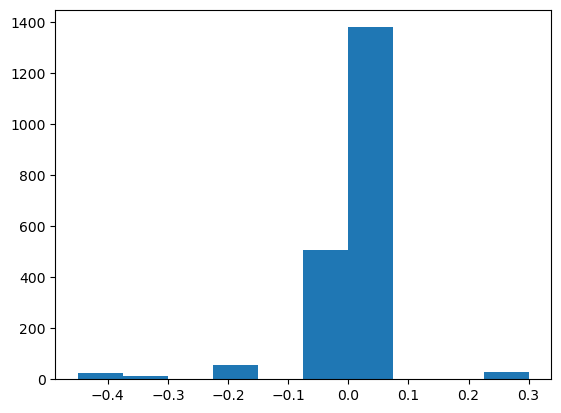

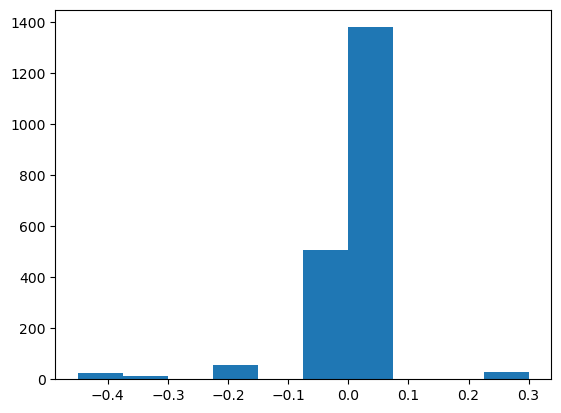

In [72]:
plt.hist(gdfEsub['tim'].values[neighTimeList[0]] - gdfEsub['tim'].values[0])
plt.show()

plt.hist(gdfEsub['tim'].values[timelist] - gdfEsub['tim'].values[0])
plt.show()

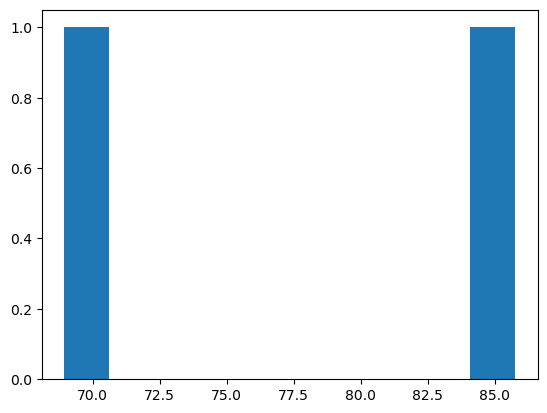

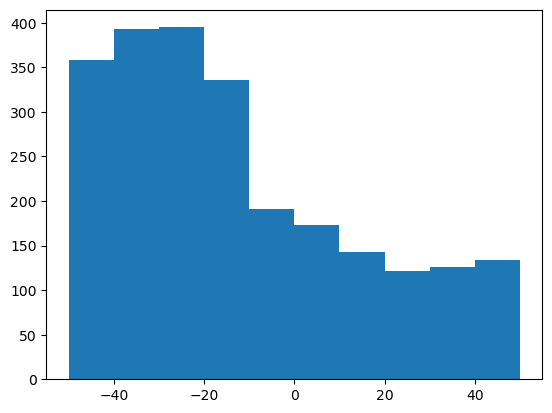

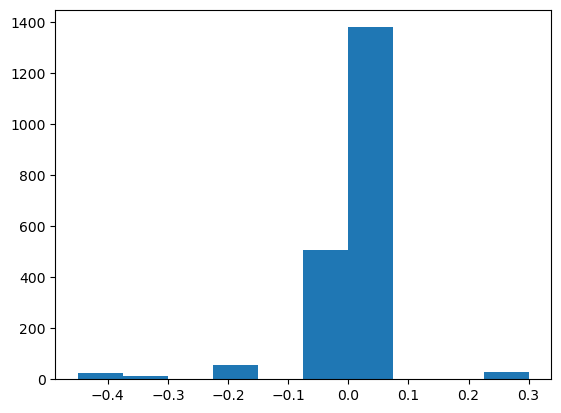

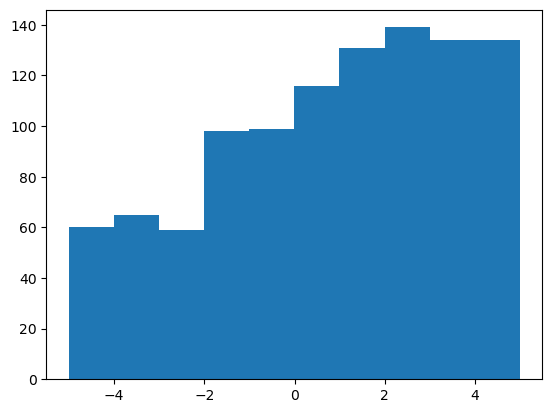

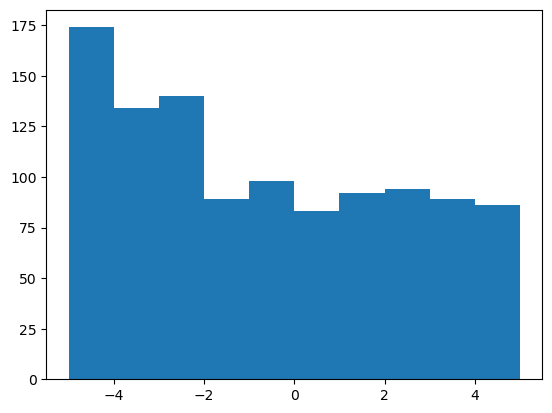

In [73]:
plt.hist(haversine_np(gdfEsub['lat'].values[proxlist],gdfEsub['lon'].values[proxlist],gdfEsub['lat'].values[i],gdfEsub['lon'].values[i]))
plt.show()

plt.hist(gdfEsub['pre'].values[preslist] - gdfEsub['pre'].values[i])
plt.show()

plt.hist(gdfEsub['tim'].values[timelist] - gdfEsub['tim'].values[i])
plt.show()

plt.hist(gdfEsub['uob'].values[uwndlist] - gdfEsub['uob'].values[i])
plt.show()

plt.hist(gdfEsub['vob'].values[vwndlist] - gdfEsub['vob'].values[i])
plt.show()

In [50]:
gdfEsub

,level_0,index,geometry,lat,lon,pre,tim,uob,vob,ob_idx,clusterIndex,compGroup
0,0,1,POINT (939536.456 -9013539.305),-80.970001,8.440000,450.0,-2.55,-13.800393,8.292113,1,-1,0
1,1,2,POINT (921725.354 -9082556.846),-81.589996,8.280000,437.0,-2.55,-11.190902,9.062214,2,-1,0
2,2,4,POINT (732482.241 -9122631.931),-81.949997,6.580000,412.0,-2.55,-10.281547,13.159780,4,-1,0
3,3,5,POINT (765878.109 -9160480.999),-82.290001,6.880000,437.0,-2.55,-9.800718,5.211134,5,-1,0
4,4,6,POINT (982951.095 -9154914.685),-82.239998,8.830000,412.0,-2.55,-9.447250,10.867818,6,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3433,38303,39518,POINT (-758374.223 -7210230.140),-64.770599,-6.812592,500.0,-1.75,-11.313062,13.482382,1822205,-1,0
3434,38304,39519,POINT (-641299.873 -7204341.091),-64.717697,-5.760895,512.0,-1.75,-12.156522,12.588447,1822206,-1,0
3435,38305,39520,POINT (-916269.343 -7249826.219),-65.126297,-8.230988,487.0,-1.75,-15.286101,20.285341,1822207,-1,0
3436,38306,39521,POINT (-886302.630 -7516225.399),-67.519402,-7.961792,475.0,-1.75,-12.071371,12.944961,1822208,-1,0


In [37]:
[print(gdfEsub['tim'].values[i])]
gdfEsub.iloc[timelist]

-2.55


,level_0,index,geometry,lat,lon,pre,tim,uob,vob,ob_idx,clusterIndex,compGroup
0,0,1,POINT (939536.456 -9013539.305),-80.970001,8.440000,450.0,-2.550000,-13.800393,8.292113,1,-1,0
1,1,2,POINT (921725.354 -9082556.846),-81.589996,8.280000,437.0,-2.550000,-11.190902,9.062214,2,-1,0
2,2,4,POINT (732482.241 -9122631.931),-81.949997,6.580000,412.0,-2.550000,-10.281547,13.159780,4,-1,0
3,3,5,POINT (765878.109 -9160480.999),-82.290001,6.880000,437.0,-2.550000,-9.800718,5.211134,5,-1,0
4,4,6,POINT (982951.095 -9154914.685),-82.239998,8.830000,412.0,-2.550000,-9.447250,10.867818,6,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3413,38282,39495,POINT (-444544.168 -7467678.544),-67.083298,-3.993408,525.0,-2.750000,-12.557368,7.250000,1822175,-1,0
3414,38283,39496,POINT (-81318.806 -7700971.149),-69.179001,-0.730499,425.0,-2.750000,-4.981193,14.466434,1822176,-1,0
3415,38284,39497,POINT (-837090.773 -7259021.593),-65.208900,-7.519714,500.0,-2.283333,-14.745225,7.840175,1822178,-1,0
3416,38285,39498,POINT (-250135.929 -7626598.769),-68.510902,-2.247009,487.0,-2.300000,-9.864149,10.214625,1822183,-1,0


In [21]:
gdfEsub

,level_0,index,geometry,lat,lon,pre,tim,uob,vob,ob_idx,clusterIndex,compGroup
0,0,1,POINT (939536.456 -9013539.305),-80.970001,8.440000,450.0,-2.55,-13.800393,8.292113,1,-1,0
1,1,2,POINT (921725.354 -9082556.846),-81.589996,8.280000,437.0,-2.55,-11.190902,9.062214,2,-1,0
2,2,4,POINT (732482.241 -9122631.931),-81.949997,6.580000,412.0,-2.55,-10.281547,13.159780,4,-1,0
3,3,5,POINT (765878.109 -9160480.999),-82.290001,6.880000,437.0,-2.55,-9.800718,5.211134,5,-1,0
4,4,6,POINT (982951.095 -9154914.685),-82.239998,8.830000,412.0,-2.55,-9.447250,10.867818,6,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3433,38303,39518,POINT (-758374.223 -7210230.140),-64.770599,-6.812592,500.0,-1.75,-11.313062,13.482382,1822205,-1,0
3434,38304,39519,POINT (-641299.873 -7204341.091),-64.717697,-5.760895,512.0,-1.75,-12.156522,12.588447,1822206,-1,0
3435,38305,39520,POINT (-916269.343 -7249826.219),-65.126297,-8.230988,487.0,-1.75,-15.286101,20.285341,1822207,-1,0
3436,38306,39521,POINT (-886302.630 -7516225.399),-67.519402,-7.961792,475.0,-1.75,-12.071371,12.944961,1822208,-1,0


In [9]:
# define a cluster index value
clusterID = -1  # first valid cluster will increment, so clusterIndex will begin at 0
# loop over component-groups
for ic in np.unique(gdfE['compGroup'].values):
    # extract all component-neighbors from a component of w
    gdfEsub = gdfE.loc[gdfE['compGroup']==ic]
    compIDX = gdfEsub.index
    print('operating on component group {:d} of {:d}, with {:d} observations'.format(ic,np.size(np.unique(gdfE['compGroup'].values)),np.size(compIDX)))
    # compute pressure and time proximity-neighbor lists among expidx[compIDX]
    neighPres = NearestNeighbors(radius=thresPres)
    neighPres.fit(np.reshape(gdfEsub['pre'].values,(-1,1)))
    neighPresList = neighPres.radius_neighbors(np.reshape(gdfEsub['pre'].values,(-1,1)),return_distance=False)
    neighTime = NearestNeighbors(radius=thresTime)
    neighTime.fit(np.reshape(gdfEsub['tim'].values,(-1,1)))
    neighTimeList = neighTime.radius_neighbors(np.reshape(gdfEsub['tim'].values,(-1,1)),return_distance=False)
    # compute uwd and vwd proximity-neighbor lists
    neighUwnd = NearestNeighbors(radius=thresUwnd)
    neighUwnd.fit(np.reshape(gdfEsub['uwd'].values,(-1,1)))
    neighVwnd = NearestNeighbors(radius=thresVwnd)
    neighVwnd.fit(np.reshape(gdfEsub['vwd'].values,(-1,1)))
    # 
    # create gdfE subset for component-group
    gdfEsub = gdfE.loc[gdfE['compGroup']==ic]
    gdfEsub = gdfEsub.reset_index()
    
    
    
    
    # decide if similarity clusters can be generated: there must be at least as many observations as the
    # minimum number of obs necessary to form a cluster in OPTICS.
    minObs = 8
    maxDist = 7.
    if (len(gdfEsub) <= minObs):
        # too few obs to cluster by OPTICS
        # no clustering necessary, these can be considered islands
        gdfE_islands = gpd.GeoDataFrame(pd.concat([gdfE_islands,gdfEsub], ignore_index=True, verify_integrity=False, sort=False))
        # reassert column types (integers tend to turn into floats after update)
        convert_dict = {'ob_idx': int,
                        'clusterIndex': int
                        }
        gdfE_islands = gdfE_islands.astype(convert_dict)
        gdfE=gdfE.drop(index=gdfEsub['level_0'].values)
    else:
        # generate OPTICS clusters and return cluster centers
        ob_sim, clusterCenters = optics_labels(gdfEsub['ob_idx'].values,ob_uwd,ob_vwd,min_obs=minObs,max_dist=maxDist)  # similarity-labels, from OPTICS clustering
        # if only a -1 cluster is discovered, clusterCenters.size == 0, and these can be considered islands
        if clusterCenters.size == 0:
            # no clustering necessary, these can be considered islands
            gdfE_islands = gpd.GeoDataFrame(pd.concat([gdfE_islands,gdfEsub], ignore_index=True, verify_integrity=False, sort=False))
            # reassert column types (integers tend to turn into floats after update)
            convert_dict = {'ob_idx': int,
                            'clusterIndex': int
                            }
            gdfE_islands = gdfE_islands.astype(convert_dict)
            gdfE=gdfE.drop(index=gdfEsub['level_0'].values)
        else:
            # use clusterCenters to initialize a k-means search to assign each observation to a cluster
            idxs = gdfEsub['ob_idx'].values
            obu = ob_uwd
            obv = ob_vwd
            n_feat = 2
            X = np.nan * np.ones((np.size(idxs),n_feat))
            feat1 = obu[idxs]
            feat2 = obv[idxs]
            X[:,0] = feat1
            X[:,1] = feat2
            clustering = KMeans(n_clusters=np.shape(clusterCenters)[0],
                                init=clusterCenters,
                                n_init=1).fit(X)
            ob_sim = clustering.labels_
            # assign ob_sim values as similGroup
            gdfEsub = gdfEsub.assign(similGroup=ob_sim)
            # loop through similGroup values
            for si in np.unique(gdfEsub['similGroup'].values):
                gdfEsubcl = gdfEsub.loc[gdfEsub['similGroup']==si]
                # loop through similarity subcluster
                for i in range(len(gdfEsubcl)):
                    # if member i has not been assigned a cluster, compute clustering around member i
                    if gdfEsubcl.iloc[i]['clusterIndex'] == -1:
                        # increment clusterID
                        clusterID = clusterID + 1
                        # Define proximity, pressure, and time neighbors among subcluster members
                        proxlist=np.where(np.isin(gdfEsubcl['level_0'].values,w.neighbors[gdfEsubcl['level_0'].values[i]]))[0]
                        preslist=np.where(np.isin(gdfEsubcl.index,neighPresList[gdfEsubcl.index[i]]))[0]
                        timelist=np.where(np.isin(gdfEsubcl.index,neighTimeList[gdfEsubcl.index[i]]))[0]
                        # Define 4d neighbors to subcluster member i
                        idx4d=np.intersect1d(proxlist,np.intersect1d(preslist,timelist))
                        # Define all members of cluster as member i and any members in idx4d
                        ids = np.append(i,idx4d)
                        # assign any member of ids with a -1 (unassigned) clusterIndex to clusterID
                        gdfEsubcl.iloc[ids, gdfEsubcl.columns.get_loc('clusterIndex')] = np.where(gdfEsubcl.iloc[ids, gdfEsubcl.columns.get_loc('clusterIndex')]==-1,
                                                                                                  clusterID,
                                                                                                  gdfEsubcl.iloc[ids, gdfEsubcl.columns.get_loc('clusterIndex')])
                # assign corresponding members of gdfE a clusterIndex value from gdfEsubcl, following clustering
                gdfE.set_index('index', inplace=True)
                gdfE.update(gdfEsubcl.set_index('index'))
                gdfE=gdfE.reset_index()  # to recover the initial structure
                # reassert column types (integers tend to turn into floats after update)
                convert_dict = {'ob_idx': int,
                                'clusterIndex': int,
                                'compGroup': int
                               }
                gdfE = gdfE.astype(convert_dict)
                gdfE = gdfE.set_crs("EPSG:4087")

operating on component group 0 of 1580, with 3438 observations
operating on component group 1 of 1580, with 7 observations
operating on component group 2 of 1579, with 2 observations
operating on component group 3 of 1578, with 3 observations
operating on component group 4 of 1577, with 2 observations
operating on component group 5 of 1576, with 3 observations
operating on component group 6 of 1575, with 4 observations
operating on component group 7 of 1574, with 5 observations
operating on component group 8 of 1573, with 128 observations
operating on component group 9 of 1573, with 45 observations
operating on component group 10 of 1573, with 18 observations
operating on component group 11 of 1573, with 7 observations
operating on component group 12 of 1572, with 3 observations
operating on component group 13 of 1571, with 4 observations
operating on component group 14 of 1570, with 3 observations
operating on component group 15 of 1569, with 3 observations
operating on component grou

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 34 of 1551, with 2 observations
operating on component group 35 of 1550, with 6 observations
operating on component group 36 of 1549, with 2 observations
operating on component group 37 of 1548, with 6 observations
operating on component group 38 of 1547, with 10 observations
operating on component group 39 of 1546, with 3 observations
operating on component group 40 of 1545, with 2 observations
operating on component group 41 of 1544, with 39 observations


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 42 of 1544, with 4 observations
operating on component group 43 of 1543, with 2 observations
operating on component group 44 of 1542, with 2 observations
operating on component group 45 of 1541, with 4 observations
operating on component group 46 of 1540, with 6 observations
operating on component group 47 of 1539, with 9 observations
operating on component group 48 of 1539, with 2 observations
operating on component group 49 of 1538, with 3 observations
operating on component group 50 of 1537, with 3 observations
operating on component group 51 of 1536, with 2 observations
operating on component group 52 of 1535, with 4 observations
operating on component group 53 of 1534, with 2 observations
operating on component group 54 of 1533, with 3 observations
operating on component group 55 of 1532, with 7 observations
operating on component group 56 of 1531, with 2 observations
operating on component group 57 of 1530, with 2 observations
operating on component g

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 82 of 1507, with 8 observations
operating on component group 83 of 1506, with 2 observations
operating on component group 84 of 1505, with 5 observations
operating on component group 85 of 1504, with 4 observations
operating on component group 86 of 1503, with 8 observations
operating on component group 87 of 1502, with 2 observations
operating on component group 88 of 1501, with 2 observations
operating on component group 89 of 1500, with 2 observations
operating on component group 90 of 1499, with 7 observations
operating on component group 91 of 1498, with 2 observations
operating on component group 92 of 1497, with 3 observations
operating on component group 93 of 1496, with 4 observations
operating on component group 94 of 1495, with 2 observations
operating on component group 95 of 1494, with 5 observations
operating on component group 96 of 1493, with 2 observations
operating on component group 97 of 1492, with 4 observations
operating on component g

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 138 of 1456, with 5 observations
operating on component group 139 of 1455, with 6 observations
operating on component group 140 of 1454, with 2 observations
operating on component group 141 of 1453, with 40 observations
operating on component group 142 of 1453, with 6 observations
operating on component group 143 of 1452, with 5 observations
operating on component group 144 of 1451, with 3 observations
operating on component group 145 of 1450, with 3 observations
operating on component group 146 of 1449, with 4 observations
operating on component group 147 of 1448, with 3 observations
operating on component group 148 of 1447, with 2 observations
operating on component group 149 of 1446, with 7 observations
operating on component group 150 of 1445, with 5 observations
operating on component group 151 of 1444, with 135 observations
operating on component group 152 of 1444, with 63 observations
operating on component group 153 of 1444, with 24 observations
ope

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 207 of 1401, with 2 observations
operating on component group 208 of 1400, with 9 observations
operating on component group 209 of 1399, with 11 observations
operating on component group 210 of 1399, with 4 observations
operating on component group 211 of 1398, with 29 observations


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 212 of 1398, with 68 observations
operating on component group 213 of 1398, with 2 observations
operating on component group 214 of 1397, with 5 observations
operating on component group 215 of 1396, with 7 observations
operating on component group 216 of 1395, with 6 observations
operating on component group 217 of 1394, with 2 observations
operating on component group 218 of 1393, with 3 observations
operating on component group 219 of 1392, with 2 observations
operating on component group 220 of 1391, with 2 observations
operating on component group 221 of 1390, with 4 observations
operating on component group 222 of 1389, with 18 observations
operating on component group 223 of 1389, with 2 observations
operating on component group 224 of 1388, with 4 observations
operating on component group 225 of 1387, with 3 observations
operating on component group 226 of 1386, with 5 observations
operating on component group 227 of 1385, with 12 observations
opera

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 241 of 1376, with 10 observations
operating on component group 242 of 1375, with 7 observations
operating on component group 243 of 1374, with 2 observations
operating on component group 244 of 1373, with 14 observations
operating on component group 245 of 1372, with 3 observations
operating on component group 246 of 1371, with 4 observations
operating on component group 247 of 1370, with 35 observations


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 248 of 1370, with 6 observations
operating on component group 249 of 1369, with 3 observations
operating on component group 250 of 1368, with 2 observations
operating on component group 251 of 1367, with 2 observations
operating on component group 252 of 1366, with 2 observations
operating on component group 253 of 1365, with 27 observations
operating on component group 254 of 1365, with 9 observations
operating on component group 255 of 1364, with 2 observations


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 256 of 1363, with 7 observations
operating on component group 257 of 1362, with 2 observations
operating on component group 258 of 1361, with 19 observations
operating on component group 259 of 1361, with 3 observations
operating on component group 260 of 1360, with 36 observations
operating on component group 261 of 1360, with 3 observations
operating on component group 262 of 1359, with 4 observations
operating on component group 263 of 1358, with 4 observations
operating on component group 264 of 1357, with 3 observations
operating on component group 265 of 1356, with 3 observations
operating on component group 266 of 1355, with 2 observations
operating on component group 267 of 1354, with 4 observations
operating on component group 268 of 1353, with 3 observations
operating on component group 269 of 1352, with 3 observations
operating on component group 270 of 1351, with 2 observations
operating on component group 271 of 1350, with 2 observations
operat

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 282 of 1342, with 12 observations
operating on component group 283 of 1341, with 3 observations
operating on component group 284 of 1340, with 6 observations
operating on component group 285 of 1339, with 2 observations
operating on component group 286 of 1338, with 3 observations
operating on component group 287 of 1337, with 206 observations


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 288 of 1337, with 3 observations
operating on component group 289 of 1336, with 4 observations
operating on component group 290 of 1335, with 82 observations
operating on component group 291 of 1335, with 12 observations
operating on component group 292 of 1335, with 4 observations
operating on component group 293 of 1334, with 8 observations
operating on component group 294 of 1333, with 2 observations
operating on component group 295 of 1332, with 3 observations
operating on component group 296 of 1331, with 2 observations
operating on component group 297 of 1330, with 2 observations
operating on component group 298 of 1329, with 3 observations
operating on component group 299 of 1328, with 4 observations
operating on component group 300 of 1327, with 10 observations
operating on component group 301 of 1326, with 4 observations
operating on component group 302 of 1325, with 4 observations
operating on component group 303 of 1324, with 3 observations
opera

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 351 of 1288, with 6 observations
operating on component group 352 of 1287, with 9 observations
operating on component group 353 of 1287, with 5 observations
operating on component group 354 of 1286, with 2 observations
operating on component group 355 of 1285, with 3 observations
operating on component group 356 of 1284, with 19 observations
operating on component group 357 of 1284, with 2 observations
operating on component group 358 of 1283, with 30 observations
operating on component group 359 of 1283, with 2 observations
operating on component group 360 of 1282, with 3 observations
operating on component group 361 of 1281, with 4588 observations
operating on component group 362 of 1281, with 2 observations
operating on component group 363 of 1280, with 125 observations
operating on component group 364 of 1280, with 2 observations
operating on component group 365 of 1279, with 2 observations
operating on component group 366 of 1278, with 2 observations
o

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 404 of 1248, with 4 observations
operating on component group 405 of 1247, with 7 observations
operating on component group 406 of 1246, with 4 observations
operating on component group 407 of 1245, with 2 observations
operating on component group 408 of 1244, with 4 observations
operating on component group 409 of 1243, with 2 observations
operating on component group 410 of 1242, with 5 observations
operating on component group 411 of 1241, with 2 observations
operating on component group 412 of 1240, with 5 observations
operating on component group 413 of 1239, with 2 observations
operating on component group 414 of 1238, with 3 observations
operating on component group 415 of 1237, with 4 observations
operating on component group 416 of 1236, with 2 observations
operating on component group 417 of 1235, with 3 observations
operating on component group 418 of 1234, with 6 observations
operating on component group 419 of 1233, with 8 observations
operatin

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 454 of 1201, with 3 observations
operating on component group 455 of 1200, with 3 observations
operating on component group 456 of 1199, with 2 observations
operating on component group 457 of 1198, with 7 observations
operating on component group 458 of 1197, with 3 observations
operating on component group 459 of 1196, with 4 observations
operating on component group 460 of 1195, with 60 observations
operating on component group 461 of 1195, with 13 observations
operating on component group 462 of 1195, with 3 observations
operating on component group 463 of 1194, with 9 observations
operating on component group 464 of 1194, with 3 observations
operating on component group 465 of 1193, with 2 observations
operating on component group 466 of 1192, with 2 observations
operating on component group 467 of 1191, with 11 observations
operating on component group 468 of 1191, with 3 observations
operating on component group 469 of 1190, with 21 observations
oper

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 477 of 1184, with 2 observations
operating on component group 478 of 1183, with 3 observations
operating on component group 479 of 1182, with 2 observations
operating on component group 480 of 1181, with 3 observations
operating on component group 481 of 1180, with 2 observations
operating on component group 482 of 1179, with 2 observations
operating on component group 483 of 1178, with 20 observations
operating on component group 484 of 1178, with 4 observations
operating on component group 485 of 1177, with 3 observations
operating on component group 486 of 1176, with 2 observations
operating on component group 487 of 1175, with 7 observations
operating on component group 488 of 1174, with 2 observations
operating on component group 489 of 1173, with 5 observations
operating on component group 490 of 1172, with 2 observations
operating on component group 491 of 1171, with 3 observations
operating on component group 492 of 1170, with 3 observations
operati

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 498 of 1165, with 13 observations
operating on component group 499 of 1165, with 4 observations
operating on component group 500 of 1164, with 3 observations
operating on component group 501 of 1163, with 9 observations
operating on component group 502 of 1163, with 8 observations
operating on component group 503 of 1162, with 2 observations
operating on component group 504 of 1161, with 4 observations
operating on component group 505 of 1160, with 3 observations
operating on component group 506 of 1159, with 2 observations
operating on component group 507 of 1158, with 3 observations
operating on component group 508 of 1157, with 39 observations
operating on component group 509 of 1157, with 2 observations
operating on component group 510 of 1156, with 4 observations
operating on component group 511 of 1155, with 4 observations
operating on component group 512 of 1154, with 3 observations
operating on component group 513 of 1153, with 2 observations
operat

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 522 of 1145, with 2 observations
operating on component group 523 of 1144, with 2 observations
operating on component group 524 of 1143, with 4 observations
operating on component group 525 of 1142, with 3 observations
operating on component group 526 of 1141, with 2 observations
operating on component group 527 of 1140, with 4 observations
operating on component group 528 of 1139, with 4 observations
operating on component group 529 of 1138, with 3 observations
operating on component group 530 of 1137, with 4 observations
operating on component group 531 of 1136, with 3 observations
operating on component group 532 of 1135, with 3 observations
operating on component group 533 of 1134, with 227 observations
operating on component group 534 of 1134, with 3 observations
operating on component group 535 of 1133, with 9 observations
operating on component group 536 of 1132, with 2 observations
operating on component group 537 of 1131, with 327 observations


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 538 of 1131, with 2 observations
operating on component group 539 of 1130, with 12 observations
operating on component group 540 of 1130, with 31 observations
operating on component group 541 of 1130, with 4 observations
operating on component group 542 of 1129, with 4 observations
operating on component group 543 of 1128, with 165 observations
operating on component group 544 of 1128, with 10 observations
operating on component group 545 of 1127, with 10 observations
operating on component group 546 of 1126, with 2 observations
operating on component group 547 of 1125, with 3 observations
operating on component group 548 of 1124, with 2 observations
operating on component group 549 of 1123, with 2 observations
operating on component group 550 of 1122, with 4 observations
operating on component group 551 of 1121, with 2 observations
operating on component group 552 of 1120, with 11 observations
operating on component group 553 of 1120, with 4 observations


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 554 of 1119, with 4 observations
operating on component group 555 of 1118, with 3 observations
operating on component group 556 of 1117, with 3 observations
operating on component group 557 of 1116, with 3 observations
operating on component group 558 of 1115, with 3 observations
operating on component group 559 of 1114, with 2 observations
operating on component group 560 of 1113, with 802 observations
operating on component group 561 of 1113, with 9 observations
operating on component group 562 of 1112, with 4 observations
operating on component group 563 of 1111, with 15 observations
operating on component group 564 of 1111, with 4 observations
operating on component group 565 of 1110, with 5 observations
operating on component group 566 of 1109, with 28 observations
operating on component group 567 of 1109, with 10 observations
operating on component group 568 of 1109, with 3 observations
operating on component group 569 of 1108, with 2 observations
ope

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 588 of 1091, with 21 observations
operating on component group 589 of 1091, with 4 observations
operating on component group 590 of 1090, with 9 observations
operating on component group 591 of 1089, with 3 observations
operating on component group 592 of 1088, with 2 observations
operating on component group 593 of 1087, with 14 observations


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 594 of 1087, with 4 observations
operating on component group 595 of 1086, with 2 observations
operating on component group 596 of 1085, with 2 observations
operating on component group 597 of 1084, with 9 observations
operating on component group 598 of 1083, with 287 observations
operating on component group 599 of 1083, with 2 observations
operating on component group 600 of 1082, with 3 observations
operating on component group 601 of 1081, with 2 observations
operating on component group 602 of 1080, with 2 observations
operating on component group 603 of 1079, with 2 observations
operating on component group 604 of 1078, with 6 observations
operating on component group 605 of 1077, with 2 observations
operating on component group 606 of 1076, with 2 observations
operating on component group 607 of 1075, with 2 observations
operating on component group 608 of 1074, with 4 observations
operating on component group 609 of 1073, with 3 observations
operat

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 648 of 1044, with 35 observations
operating on component group 649 of 1044, with 45 observations
operating on component group 650 of 1044, with 2 observations
operating on component group 651 of 1043, with 12 observations
operating on component group 652 of 1042, with 2 observations
operating on component group 653 of 1041, with 8 observations
operating on component group 654 of 1040, with 16 observations
operating on component group 655 of 1040, with 2 observations
operating on component group 656 of 1039, with 3 observations
operating on component group 657 of 1038, with 4 observations
operating on component group 658 of 1037, with 6 observations


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 659 of 1036, with 18 observations
operating on component group 660 of 1036, with 4 observations
operating on component group 661 of 1035, with 3 observations
operating on component group 662 of 1034, with 24 observations
operating on component group 663 of 1034, with 6 observations
operating on component group 664 of 1033, with 2 observations
operating on component group 665 of 1032, with 2 observations
operating on component group 666 of 1031, with 2 observations
operating on component group 667 of 1030, with 12 observations
operating on component group 668 of 1030, with 2 observations
operating on component group 669 of 1029, with 11 observations
operating on component group 670 of 1029, with 36 observations
operating on component group 671 of 1029, with 4 observations
operating on component group 672 of 1028, with 3 observations
operating on component group 673 of 1027, with 2 observations
operating on component group 674 of 1026, with 5 observations
ope

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 699 of 1003, with 4 observations
operating on component group 700 of 1002, with 4 observations
operating on component group 701 of 1001, with 2 observations
operating on component group 702 of 1000, with 5 observations
operating on component group 703 of 999, with 10 observations
operating on component group 704 of 999, with 3 observations
operating on component group 705 of 998, with 2 observations
operating on component group 706 of 997, with 2 observations
operating on component group 707 of 996, with 3 observations
operating on component group 708 of 995, with 13 observations
operating on component group 709 of 995, with 8 observations
operating on component group 710 of 994, with 2 observations
operating on component group 711 of 993, with 53 observations
operating on component group 712 of 993, with 5 observations
operating on component group 713 of 992, with 4 observations
operating on component group 714 of 991, with 5 observations
operating on comp

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 722 of 984, with 2 observations
operating on component group 723 of 983, with 4 observations
operating on component group 724 of 982, with 8 observations
operating on component group 725 of 981, with 2 observations
operating on component group 726 of 980, with 3 observations
operating on component group 727 of 979, with 2 observations
operating on component group 728 of 978, with 5 observations
operating on component group 729 of 977, with 4 observations
operating on component group 730 of 976, with 3 observations
operating on component group 731 of 975, with 4 observations
operating on component group 732 of 974, with 178 observations
operating on component group 733 of 974, with 2 observations
operating on component group 734 of 973, with 2 observations
operating on component group 735 of 972, with 2 observations
operating on component group 736 of 971, with 185 observations
operating on component group 737 of 971, with 12 observations
operating on compon

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 797 of 924, with 8 observations
operating on component group 798 of 923, with 2 observations
operating on component group 799 of 922, with 8 observations
operating on component group 800 of 921, with 4 observations
operating on component group 801 of 920, with 7 observations
operating on component group 802 of 919, with 4 observations
operating on component group 803 of 918, with 4 observations
operating on component group 804 of 917, with 5 observations
operating on component group 805 of 916, with 2 observations
operating on component group 806 of 915, with 2 observations
operating on component group 807 of 914, with 2 observations
operating on component group 808 of 913, with 80 observations
operating on component group 809 of 913, with 2 observations
operating on component group 810 of 912, with 3 observations
operating on component group 811 of 911, with 6 observations
operating on component group 812 of 910, with 2 observations
operating on component 

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 846 of 878, with 2 observations
operating on component group 847 of 877, with 4 observations
operating on component group 848 of 876, with 2 observations
operating on component group 849 of 875, with 8 observations
operating on component group 850 of 874, with 2 observations
operating on component group 851 of 873, with 7 observations
operating on component group 852 of 872, with 3 observations
operating on component group 853 of 871, with 12 observations
operating on component group 854 of 871, with 2 observations
operating on component group 855 of 870, with 22 observations
operating on component group 856 of 870, with 3 observations
operating on component group 857 of 869, with 28 observations
operating on component group 858 of 869, with 2 observations
operating on component group 859 of 868, with 8 observations
operating on component group 860 of 867, with 2 observations
operating on component group 861 of 866, with 2 observations
operating on componen

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 872 of 855, with 21 observations
operating on component group 873 of 855, with 5 observations
operating on component group 874 of 854, with 2 observations
operating on component group 875 of 853, with 11 observations
operating on component group 876 of 853, with 15 observations
operating on component group 877 of 853, with 3 observations
operating on component group 878 of 852, with 2 observations
operating on component group 879 of 851, with 8 observations
operating on component group 880 of 850, with 4 observations
operating on component group 881 of 849, with 7 observations
operating on component group 882 of 848, with 3 observations
operating on component group 883 of 847, with 5 observations
operating on component group 884 of 846, with 2 observations
operating on component group 885 of 845, with 2 observations
operating on component group 886 of 844, with 11 observations
operating on component group 887 of 844, with 5 observations
operating on compone

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 905 of 829, with 2 observations
operating on component group 906 of 828, with 4 observations
operating on component group 907 of 827, with 3 observations
operating on component group 908 of 826, with 2 observations
operating on component group 909 of 825, with 2 observations
operating on component group 910 of 824, with 2 observations
operating on component group 911 of 823, with 2 observations
operating on component group 912 of 822, with 3 observations
operating on component group 913 of 821, with 2 observations
operating on component group 914 of 820, with 7 observations
operating on component group 915 of 819, with 6 observations
operating on component group 916 of 818, with 47 observations
operating on component group 917 of 818, with 6 observations
operating on component group 918 of 817, with 3 observations
operating on component group 919 of 816, with 5931 observations
operating on component group 920 of 816, with 2 observations
operating on compone

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 1007 of 751, with 2 observations
operating on component group 1008 of 750, with 17 observations
operating on component group 1009 of 750, with 17 observations
operating on component group 1010 of 750, with 3 observations
operating on component group 1011 of 749, with 3 observations
operating on component group 1012 of 748, with 3 observations
operating on component group 1013 of 747, with 5 observations
operating on component group 1014 of 746, with 4 observations
operating on component group 1015 of 745, with 3 observations
operating on component group 1016 of 744, with 16 observations
operating on component group 1017 of 744, with 3 observations
operating on component group 1018 of 743, with 2 observations
operating on component group 1019 of 742, with 8 observations
operating on component group 1020 of 741, with 2 observations
operating on component group 1021 of 740, with 31 observations
operating on component group 1022 of 740, with 3 observations
oper

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 1028 of 736, with 99 observations
operating on component group 1029 of 736, with 8 observations
operating on component group 1030 of 735, with 14 observations
operating on component group 1031 of 735, with 2 observations
operating on component group 1032 of 734, with 5 observations
operating on component group 1033 of 733, with 2 observations
operating on component group 1034 of 732, with 6 observations
operating on component group 1035 of 731, with 2 observations
operating on component group 1036 of 730, with 2 observations
operating on component group 1037 of 729, with 4 observations
operating on component group 1038 of 728, with 84 observations
operating on component group 1039 of 728, with 3 observations
operating on component group 1040 of 727, with 4 observations
operating on component group 1041 of 726, with 52 observations
operating on component group 1042 of 726, with 68 observations
operating on component group 1043 of 726, with 53 observations
op

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 1124 of 666, with 6 observations
operating on component group 1125 of 665, with 3 observations
operating on component group 1126 of 664, with 2 observations
operating on component group 1127 of 663, with 9 observations
operating on component group 1128 of 662, with 2 observations
operating on component group 1129 of 661, with 216 observations


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 1130 of 661, with 4 observations
operating on component group 1131 of 660, with 4 observations
operating on component group 1132 of 659, with 2 observations
operating on component group 1133 of 658, with 6 observations
operating on component group 1134 of 657, with 3 observations
operating on component group 1135 of 656, with 3 observations
operating on component group 1136 of 655, with 3 observations
operating on component group 1137 of 654, with 6 observations
operating on component group 1138 of 653, with 121 observations
operating on component group 1139 of 653, with 4 observations
operating on component group 1140 of 652, with 394 observations
operating on component group 1141 of 652, with 2 observations
operating on component group 1142 of 651, with 3 observations
operating on component group 1143 of 650, with 6 observations
operating on component group 1144 of 649, with 2 observations
operating on component group 1145 of 648, with 2 observations
oper

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 1200 of 606, with 9 observations
operating on component group 1201 of 605, with 2 observations
operating on component group 1202 of 604, with 3 observations
operating on component group 1203 of 603, with 3 observations
operating on component group 1204 of 602, with 2 observations
operating on component group 1205 of 601, with 4 observations
operating on component group 1206 of 600, with 2 observations
operating on component group 1207 of 599, with 3 observations
operating on component group 1208 of 598, with 6 observations
operating on component group 1209 of 597, with 2 observations
operating on component group 1210 of 596, with 8 observations
operating on component group 1211 of 595, with 6 observations
operating on component group 1212 of 594, with 4 observations
operating on component group 1213 of 593, with 3 observations
operating on component group 1214 of 592, with 2 observations
operating on component group 1215 of 591, with 4 observations
operatin

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 1264 of 549, with 3 observations
operating on component group 1265 of 548, with 2 observations
operating on component group 1266 of 547, with 8 observations
operating on component group 1267 of 546, with 4 observations
operating on component group 1268 of 545, with 2 observations
operating on component group 1269 of 544, with 4 observations
operating on component group 1270 of 543, with 2 observations
operating on component group 1271 of 542, with 3 observations
operating on component group 1272 of 541, with 154 observations
operating on component group 1273 of 541, with 37 observations
operating on component group 1274 of 541, with 3 observations
operating on component group 1275 of 540, with 7 observations
operating on component group 1276 of 539, with 6 observations
operating on component group 1277 of 538, with 5 observations
operating on component group 1278 of 537, with 3 observations
operating on component group 1279 of 536, with 2 observations
opera

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 1317 of 504, with 2 observations
operating on component group 1318 of 503, with 2 observations
operating on component group 1319 of 502, with 4 observations
operating on component group 1320 of 501, with 4 observations
operating on component group 1321 of 500, with 5 observations
operating on component group 1322 of 499, with 2 observations
operating on component group 1323 of 498, with 11 observations
operating on component group 1324 of 498, with 3 observations
operating on component group 1325 of 497, with 2 observations
operating on component group 1326 of 496, with 25 observations
operating on component group 1327 of 496, with 5 observations
operating on component group 1328 of 495, with 37 observations
operating on component group 1329 of 495, with 2 observations
operating on component group 1330 of 494, with 3 observations
operating on component group 1331 of 493, with 15 observations
operating on component group 1332 of 493, with 2 observations
oper

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 1336 of 490, with 4 observations
operating on component group 1337 of 489, with 2 observations
operating on component group 1338 of 488, with 6 observations
operating on component group 1339 of 487, with 26 observations
operating on component group 1340 of 487, with 2 observations
operating on component group 1341 of 486, with 3 observations
operating on component group 1342 of 485, with 25 observations
operating on component group 1343 of 485, with 13 observations
operating on component group 1344 of 484, with 2 observations
operating on component group 1345 of 483, with 2 observations
operating on component group 1346 of 482, with 2 observations
operating on component group 1347 of 481, with 7 observations
operating on component group 1348 of 480, with 19 observations
operating on component group 1349 of 480, with 50 observations


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 1350 of 480, with 27 observations
operating on component group 1351 of 480, with 6 observations
operating on component group 1352 of 479, with 36 observations
operating on component group 1353 of 479, with 21 observations
operating on component group 1354 of 479, with 29 observations
operating on component group 1355 of 479, with 35 observations
operating on component group 1356 of 479, with 9 observations
operating on component group 1357 of 479, with 5 observations
operating on component group 1358 of 478, with 2 observations
operating on component group 1359 of 477, with 2 observations
operating on component group 1360 of 476, with 2 observations
operating on component group 1361 of 475, with 29 observations
operating on component group 1362 of 475, with 11 observations
operating on component group 1363 of 474, with 4 observations
operating on component group 1364 of 473, with 7 observations
operating on component group 1365 of 472, with 4 observations
o

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 1445 of 410, with 6 observations
operating on component group 1446 of 409, with 7 observations
operating on component group 1447 of 408, with 2 observations
operating on component group 1448 of 407, with 3 observations
operating on component group 1449 of 406, with 2 observations
operating on component group 1450 of 405, with 2 observations
operating on component group 1451 of 404, with 2 observations
operating on component group 1452 of 403, with 2 observations
operating on component group 1453 of 402, with 3 observations
operating on component group 1454 of 401, with 159 observations
operating on component group 1455 of 401, with 24 observations
operating on component group 1456 of 401, with 2 observations
operating on component group 1457 of 400, with 114 observations
operating on component group 1458 of 400, with 2 observations
operating on component group 1459 of 399, with 2 observations
operating on component group 1460 of 398, with 5 observations
ope

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 1483 of 378, with 3 observations
operating on component group 1484 of 377, with 2 observations
operating on component group 1485 of 376, with 2 observations
operating on component group 1486 of 375, with 2 observations
operating on component group 1487 of 374, with 51 observations
operating on component group 1488 of 374, with 2 observations
operating on component group 1489 of 373, with 2 observations
operating on component group 1490 of 372, with 2 observations
operating on component group 1491 of 371, with 46 observations
operating on component group 1492 of 371, with 14 observations
operating on component group 1493 of 371, with 2 observations
operating on component group 1494 of 370, with 15 observations
operating on component group 1495 of 370, with 6 observations
operating on component group 1496 of 369, with 7 observations
operating on component group 1497 of 368, with 3 observations
operating on component group 1498 of 367, with 3 observations
oper

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


operating on component group 1568 of 304, with 6 observations
operating on component group 1569 of 303, with 2 observations
operating on component group 1570 of 302, with 4 observations
operating on component group 1571 of 301, with 16 observations
operating on component group 1572 of 301, with 2 observations
operating on component group 1573 of 300, with 5 observations
operating on component group 1574 of 299, with 3 observations
operating on component group 1575 of 298, with 2 observations
operating on component group 1576 of 297, with 5 observations
operating on component group 1577 of 296, with 2 observations
operating on component group 1578 of 295, with 3 observations
operating on component group 1579 of 294, with 2 observations


In [10]:
# Assign each observation in gdfE_islands to its own cluster, incrementing from max(gdfE['clusterIndex'])
gdfE_islands['clusterIndex']=np.arange(max(gdfE['clusterIndex'])+1,max(gdfE['clusterIndex'])+1+len(gdfE_islands))
# Concatenate gdfE and gdfE_islands together to regenerate entire dataframe
gdfE2 = gpd.GeoDataFrame(pd.concat([gdfE,gdfE_islands], ignore_index=True, verify_integrity=False, sort=False))
gdfE2

,index,geometry,lat,lon,pre,tim,uob,vob,ob_idx,clusterIndex,compGroup,level_0
0,1,POINT (939536.456 -9013539.305),-80.970001,8.440000,450.0,-2.55,-13.800393,8.292113,1,1984,0.0,NaN
1,2,POINT (921725.354 -9082556.846),-81.589996,8.280000,437.0,-2.55,-11.190902,9.062214,2,0,0.0,NaN
2,4,POINT (732482.241 -9122631.931),-81.949997,6.580000,412.0,-2.55,-10.281547,13.159780,4,2057,0.0,NaN
3,5,POINT (765878.109 -9160480.999),-82.290001,6.880000,437.0,-2.55,-9.800718,5.211134,5,545,0.0,NaN
4,6,POINT (982951.095 -9154914.685),-82.239998,8.830000,412.0,-2.55,-9.447250,10.867818,6,43,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
39716,39715,POINT (-391979.273 8014469.127),71.995201,-3.521210,550.0,-2.30,9.053615,10.414992,1850176,31087,1578.0,33446.0
39717,39716,POINT (-391109.589 8010216.681),71.957001,-3.513397,550.0,-2.30,9.053615,10.414992,1850177,31088,1578.0,33447.0
39718,39719,POINT (-374711.299 7996491.138),71.833702,-3.366089,525.0,-2.05,9.522121,13.106075,1850181,31089,1578.0,33450.0
39719,39717,POINT (-262257.143 8251001.813),74.120010,-2.355896,550.0,-2.05,5.768426,9.600274,1850178,31090,1579.0,33448.0


In [11]:
np.max(gdfE2['clusterIndex'].values)
nMems=[]
for i in range(np.max(gdfE2['clusterIndex'].values)):
    nMems.append(len(gdfE2.loc[gdfE2['clusterIndex']==i]))
nMems=np.asarray(nMems)

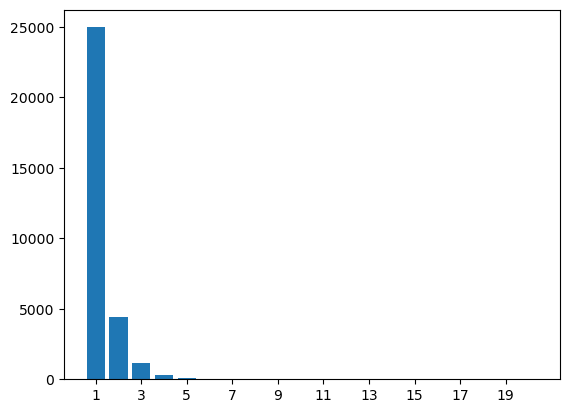

39721 observations reduced to 31091 clusters


In [12]:
h,x=np.histogram(a=nMems,bins=np.arange(0.5,20.51,1.))
xc=0.5*(x[0:-1] + x[1:])
plt.bar(x=xc,height=h)
plt.xticks(ticks=xc[::2],labels=xc[::2].astype(int))
plt.show()
print('{:d} observations reduced to {:d} clusters'.format(len(gdfE2),max(gdfE2['clusterIndex'])))